In [1]:
import sys
sys.path.append("..")

import pandas as pd

from torch.utils.data import DataLoader
from model_zoo import get_model
from dataset_zoo import VG_Relation, VG_Attribution, COCO_Order, Flickr30k_Order

In [2]:
# Please put your data root directory below. We'll download VG-Relation and VG-Attribution images here. 
# Will be a 1GB zip file (a subset of GQA).
root_dir="~/.cache" 


In [3]:
model, preprocess = get_model(model_name="openai-clip:ViT-B/32", device="cpu", root_dir=root_dir)

In [4]:
# Get the VG-R dataset
vgr_dataset = VG_Relation(image_preprocess=preprocess, download=False, root_dir=root_dir)
vgr_dataset.dataset = vgr_dataset.dataset[:1000]
vgr_loader = DataLoader(vgr_dataset, batch_size=1, shuffle=False)

print(len(vgr_dataset))

1000


In [5]:
print(vgr_dataset[0]["image_options"][0].shape)
for ex in vgr_loader:
    break
    if len(ex['image_options']) > 1:
        print(f"length of options: {len(ex['image_options'])}")

torch.Size([3, 224, 224])


In [6]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="cuda",
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

/home/loic/projects/vision-language-models-are-bows/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.52s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [7]:
import torchvision.transforms as T
normalize = T.Normalize(
        mean=[-m / s for m, s in zip([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])],
        std=[1/s for s in [0.229, 0.224, 0.225]]
    )

to_pil = T.ToPILImage()


In [ ]:
from tqdm import tqdm
from PIL import Image
from io import BytesIO
import base64


def get_retrieval_scores_batched(model, loader):
    tqdm_loader = tqdm(loader)
    tqdm_loader.set_description("Computing retrieval scores")
    image_scores = []
    no_image_scores = []
    image_correct = []
    no_image_correct = []
    probability_increase = []
    
    for batch in tqdm_loader:
        image = batch['image_options'][0][0]
        image = normalize(image)
        image = to_pil(image)

        image_path = "data/test.png"
        image.save(image_path)
        with open(image_path, "rb") as f:
            encoded_image = base64.b64encode(f.read())
        encoded_image = encoded_image.decode("utf-8")

        with_image_perplexities = []
        no_image_perplexities= []
        with_image_log_probs = []
        no_image_log_probs = []

        for add_image in [False, True]:
            for i in range(2):
                text = batch['caption_options'][i][0]
                messages = []
                if add_image:
                    messages.append(
                        {
                            "role": "user",
                            "content": [
                                {
                                    "type": "image",
                                    "image": "file://" + image_path
                                },
                            ]
                        }
                    )

                messages.append(
                    {
                        "role": "assistant",
                        "content": [
                            {
                                "type": "text",
                                "text": text
                            }
                        ]
                    }
                )

                text = processor.apply_chat_template(messages, tokenize=False, add_generation=False)
                tokenized_text = processor.apply_chat_template(messages[-1:], tokenize=True, add_special_tokens=False, return_tensors="pt")
                tokenized_text = tokenized_text.to(model.device)

                image_inputs, video_inputs = process_vision_info(messages)
                inputs = processor(
                    text=[text],
                    images=image_inputs,
                    videos=video_inputs,
                    padding=True,
                    return_tensors="pt",
                )
                inputs = inputs.to(model.device)

                outputs = model(**inputs)
                logits = outputs.logits
                log_probs = logits.log_softmax(dim=-1)[:,-tokenized_text.shape[1]:-1]
                
                selected_log_probs = log_probs.gather(dim=-1, index=tokenized_text[:, 1:].unsqueeze(-1)).squeeze(-1)
                perplexity = (-selected_log_probs.mean()).exp().item()
                if add_image:
                    with_image_perplexities.append(perplexity)
                    with_image_log_probs.append(selected_log_probs.sum())
                else:
                    no_image_perplexities.append(perplexity)
                    no_image_log_probs.append(selected_log_probs.sum())


        print(f"with image perplexities: {with_image_perplexities}")
        print(f"no image perplexities: {no_image_perplexities}")
        # since the correct caption is always the second one
        with_image_correct = with_image_perplexities[1] < with_image_perplexities[0]
        no_image_correct = no_image_perplexities[1] < no_image_perplexities[0]
        ratio_image = with_image_log_probs[1] - with_image_log_probs[0]
        ratio_no_image = no_image_log_probs[1] - no_image_log_probs[0]
        probability_increase = (ratio_image - ratio_no_image).exp().item()

        image_scores.append([1/ ppl for ppl in with_image_perplexities])
        no_image_scores.append([1/ ppl for ppl in no_image_perplexities])


        print(f"ratio with image: {ratio_image.exp().item()}")
        print(f"ratio without image: {ratio_no_image.exp().item()}")
        print(f"with image correct: {with_image_correct}")
        print(f"no image correct: {no_image_correct}")
        print(f"probability increase factor: {probability_increase}")
        print(batch["caption_options"])
        print()

    return {
        "image_scores": image_scores,
        "no_image_scores": no_image_scores,
        "image_correct": image_correct,
        "no_image_correct": no_image_correct,
        "probability_increase": probability_increase
    }








In [9]:

# Compute the scores for each test case
vgr_output = get_retrieval_scores_batched(model, vgr_loader)
vgr_image_scores = vgr_output["image_scores"]
vgr_no_image_scores = vgr_output["no_image_scores"]
vgr_image_correct = vgr_output["image_correct"]
vgr_no_image_correct = vgr_output["no_image_correct"]
vgr_probability_increase = vgr_output["probability_increase"]


Computing retrieval scores:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing retrieval scores:   0%|          | 1/1000 [00:02<38:25,  2.31s/it]

with image perplexities: [2320.0, 2544.0]
no image perplexities: [536.0, 604.0]
ratio with image: 0.0498046875
ratio without image: 0.0498046875
with image correct: False
no image correct: False
probability increase factor: 1.0
[('the shirt is to the left of the door',), ('the door is to the left of the shirt',)]



Computing retrieval scores:   0%|          | 2/1000 [00:04<35:22,  2.13s/it]

with image perplexities: [1928.0, 1984.0]
no image perplexities: [444.0, 520.0]
ratio with image: 1.0
ratio without image: 0.018310546875
with image correct: False
no image correct: False
probability increase factor: 54.5
[('the man is to the left of the door',), ('the door is to the left of the man',)]



Computing retrieval scores:   0%|          | 3/1000 [00:06<34:26,  2.07s/it]

with image perplexities: [5920.0, 3600.0]
no image perplexities: [968.0, 664.0]
ratio with image: 59904.0
ratio without image: 1096.0
with image correct: True
no image correct: True
probability increase factor: 54.5
[('the shirt is wearing the man',), ('the man is wearing the shirt',)]



Computing retrieval scores:   0%|          | 4/1000 [00:08<35:14,  2.12s/it]

with image perplexities: [2464.0, 1648.0]
no image perplexities: [828.0, 804.0]
ratio with image: 8096.0
ratio without image: 2.71875
with image correct: True
no image correct: True
probability increase factor: 2976.0
[('the train car is on the man',), ('the man is on the train car',)]



Computing retrieval scores:   0%|          | 5/1000 [00:10<34:57,  2.11s/it]

with image perplexities: [2048.0, 1928.0]
no image perplexities: [502.0, 458.0]
ratio with image: 7.375
ratio without image: 20.125
with image correct: True
no image correct: True
probability increase factor: 0.3671875
[('the door is to the right of the man',), ('the man is to the right of the door',)]



Computing retrieval scores:   1%|          | 6/1000 [00:12<34:55,  2.11s/it]

with image perplexities: [2544.0, 1496.0]
no image perplexities: [856.0, 776.0]
ratio with image: 59904.0
ratio without image: 20.125
with image correct: True
no image correct: True
probability increase factor: 2976.0
[('the train car is in the man',), ('the man is in the train car',)]



Computing retrieval scores:   1%|          | 7/1000 [00:14<34:03,  2.06s/it]

with image perplexities: [2720.0, 2256.0]
no image perplexities: [604.0, 552.0]
ratio with image: 148.0
ratio without image: 7.375
with image correct: True
no image correct: True
probability increase factor: 20.125
[('the door is to the right of the shirt',), ('the shirt is to the right of the door',)]



Computing retrieval scores:   1%|          | 8/1000 [00:16<34:18,  2.08s/it]

with image perplexities: [1368.0, 908.0]
no image perplexities: [940.0, 856.0]
ratio with image: 8096.0
ratio without image: 2.71875
with image correct: True
no image correct: True
probability increase factor: 2976.0
[('the plate is on the banana',), ('the banana is on the plate',)]



Computing retrieval scores:   1%|          | 9/1000 [00:18<34:15,  2.07s/it]

with image perplexities: [2976.0, 2544.0]
no image perplexities: [732.0, 1000.0]
ratio with image: 54.5
ratio without image: 0.002471923828125
with image correct: True
no image correct: False
probability increase factor: 22016.0
[('the plate is under the table',), ('the table is under the plate',)]



Computing retrieval scores:   1%|          | 10/1000 [00:20<34:15,  2.08s/it]

with image perplexities: [3168.0, 2544.0]
no image perplexities: [880.0, 1240.0]
ratio with image: 54.5
ratio without image: 0.000335693359375
with image correct: True
no image correct: False
probability increase factor: 162816.0
[('the plate is below the table',), ('the table is below the plate',)]



Computing retrieval scores:   1%|          | 11/1000 [00:22<33:28,  2.03s/it]

with image perplexities: [1408.0, 880.0]
no image perplexities: [940.0, 856.0]
ratio with image: 22016.0
ratio without image: 2.71875
with image correct: True
no image correct: True
probability increase factor: 8096.0
[('the plate is on the banana',), ('the banana is on the plate',)]



Computing retrieval scores:   1%|          | 12/1000 [00:24<33:37,  2.04s/it]

with image perplexities: [3376.0, 1752.0]
no image perplexities: [940.0, 708.0]
ratio with image: 442368.0
ratio without image: 404.0
with image correct: True
no image correct: True
probability increase factor: 1096.0
[('the table is on the banana',), ('the banana is on the table',)]



Computing retrieval scores:   1%|▏         | 13/1000 [00:26<32:58,  2.00s/it]

with image perplexities: [1496.0, 1592.0]
no image perplexities: [1128.0, 1096.0]
ratio with image: 0.1357421875
ratio without image: 2.71875
with image correct: False
no image correct: True
probability increase factor: 0.0498046875
[('the banana is with the plate',), ('the plate is with the banana',)]



Computing retrieval scores:   1%|▏         | 14/1000 [00:28<33:18,  2.03s/it]

with image perplexities: [1456.0, 1168.0]
no image perplexities: [552.0, 472.0]
ratio with image: 404.0
ratio without image: 54.5
with image correct: True
no image correct: True
probability increase factor: 7.375
[('the table is on top of the plate',), ('the plate is on top of the table',)]



Computing retrieval scores:   2%|▏         | 15/1000 [00:30<32:22,  1.97s/it]

with image perplexities: [2976.0, 1984.0]
no image perplexities: [880.0, 644.0]
ratio with image: 8096.0
ratio without image: 404.0
with image correct: True
no image correct: True
probability increase factor: 20.125
[('the table is on the plate',), ('the plate is on the table',)]



Computing retrieval scores:   2%|▏         | 15/1000 [00:30<33:54,  2.07s/it]


KeyboardInterrupt: 

['the shirt is to the left of the door', 'the door is to the left of the shirt']


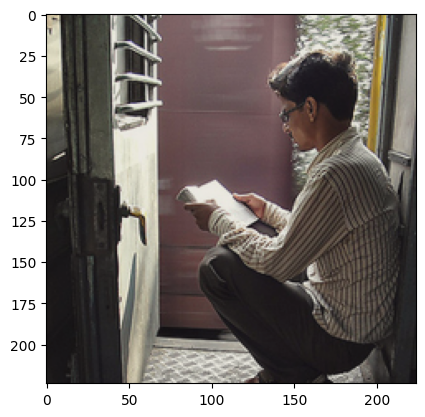

In [ ]:
import PIL
import matplotlib.pyplot as plt
#print(vgr_dataset[0])
for idx in range(0, 1):
    vgr_dataset[0]["image_options"][0].shape
    print(vgr_dataset[idx]["caption_options"])
    image = normalize(vgr_dataset[idx]["image_options"][0])
    image = to_pil(image)
    plt.imshow(image)
    plt.show()

In [ ]:
# Evaluate the macro accuracy
vgr_records = vgr_dataset.evaluate_scores(vgr_scores)
symmetric = ['adjusting', 'attached to', 'between', 'bigger than', 'biting', 'boarding', 'brushing', 'chewing', 'cleaning', 'climbing', 'close to', 'coming from', 'coming out of', 'contain', 'crossing', 'dragging', 'draped over', 'drinking', 'drinking from', 'driving', 'driving down', 'driving on', 'eating from', 'eating in', 'enclosing', 'exiting', 'facing', 'filled with', 'floating in', 'floating on', 'flying', 'flying above', 'flying in', 'flying over', 'flying through', 'full of', 'going down', 'going into', 'going through', 'grazing in', 'growing in', 'growing on', 'guiding', 'hanging from', 'hanging in', 'hanging off', 'hanging over', 'higher than', 'holding onto', 'hugging', 'in between', 'jumping off', 'jumping on', 'jumping over', 'kept in', 'larger than', 'leading', 'leaning over', 'leaving', 'licking', 'longer than', 'looking in', 'looking into', 'looking out', 'looking over', 'looking through', 'lying next to', 'lying on top of', 'making', 'mixed with', 'mounted on', 'moving', 'on the back of', 'on the edge of', 'on the front of', 'on the other side of', 'opening', 'painted on', 'parked at', 'parked beside', 'parked by', 'parked in', 'parked in front of', 'parked near', 'parked next to', 'perched on', 'petting', 'piled on', 'playing', 'playing in', 'playing on', 'playing with', 'pouring', 'reaching for', 'reading', 'reflected on', 'riding on', 'running in', 'running on', 'running through', 'seen through', 'sitting behind', 'sitting beside', 'sitting by', 'sitting in front of', 'sitting near', 'sitting next to', 'sitting under', 'skiing down', 'skiing on', 'sleeping in', 'sleeping on', 'smiling at', 'sniffing', 'splashing', 'sprinkled on', 'stacked on', 'standing against', 'standing around', 'standing behind', 'standing beside', 'standing in front of', 'standing near', 'standing next to', 'staring at', 'stuck in', 'surrounding', 'swimming in', 'swinging', 'talking to', 'topped with', 'touching', 'traveling down', 'traveling on', 'tying', 'typing on', 'underneath', 'wading in', 'waiting for', 'walking across', 'walking by', 'walking down', 'walking next to', 'walking through', 'working in', 'working on', 'worn on', 'wrapped around', 'wrapped in', 'by', 'of', 'near', 'next to', 'with', 'beside', 'on the side of', 'around']
df = pd.DataFrame(vgr_records)
df = df[~df.Relation.isin(symmetric)]
print(f"VG-Relation Macro Accuracy: {df.Accuracy.mean()}")

VG-Relation Macro Accuracy: 0.5929826793878659


In [ ]:
# Get the VG-A dataset
vga_dataset = VG_Attribution(image_preprocess=preprocess, download=True, root_dir=root_dir)
vga_loader = DataLoader(vga_dataset, batch_size=16, shuffle=False)
# Compute the scores for each test case
vga_scores = model.get_retrieval_scores_batched(vga_loader)


Computing retrieval scores: 100%|██████████| 1797/1797 [03:57<00:00,  7.56it/s]


In [ ]:
# Evaluate the macro accuracy
vga_records = vga_dataset.evaluate_scores(vga_scores)
df = pd.DataFrame(vga_records)
print(f"VG-Attribution Macro Accuracy: {df.Accuracy.mean()}")

VG-Attribution Macro Accuracy: 0.628669424087555


['the wavy bed and the round headboard', 'the round bed and the wavy headboard']


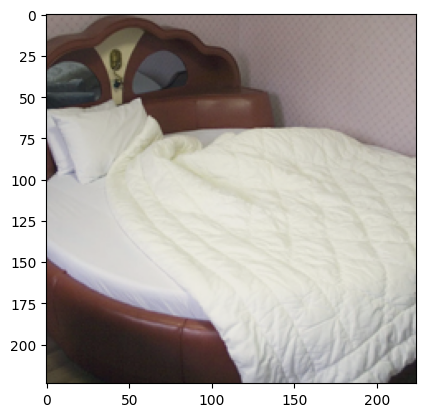

['the young shirt and the brown man', 'the brown shirt and the young man']


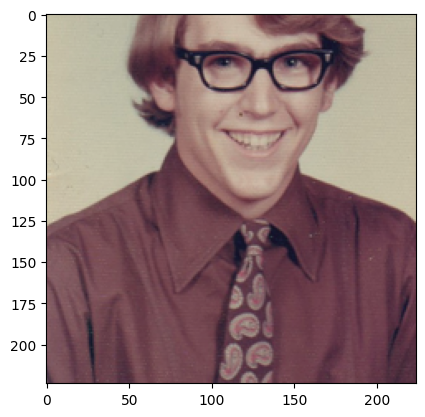

['the concrete tractor and the yellow cow', 'the yellow tractor and the concrete cow']


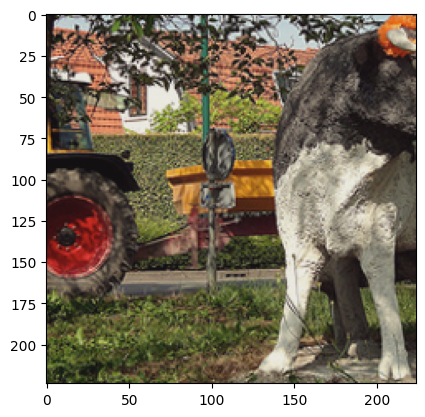

['the open ground and the concrete sky', 'the concrete ground and the open sky']


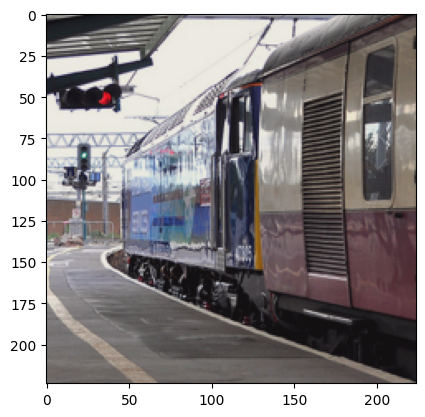

['the stained dog and the tan floor', 'the tan dog and the stained floor']


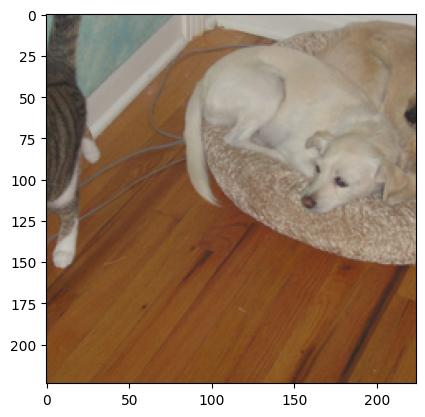

['the reading book and the open people', 'the open book and the reading people']


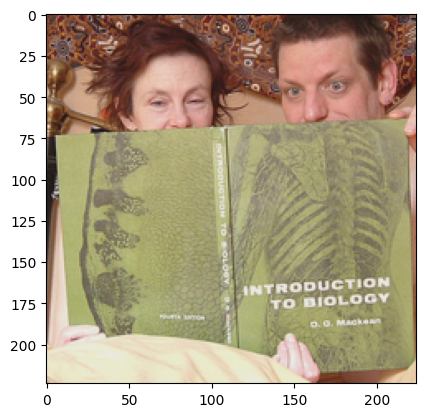

['the metal seat and the up pipe', 'the up seat and the metal pipe']


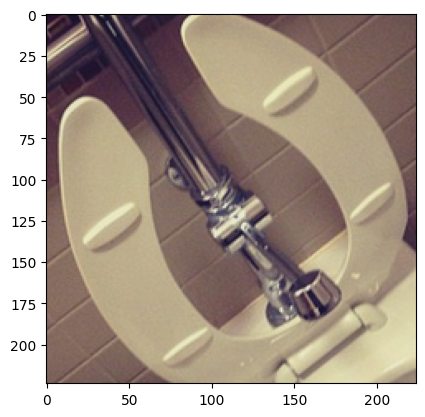

['the brown sheep and the white hay', 'the white sheep and the brown hay']


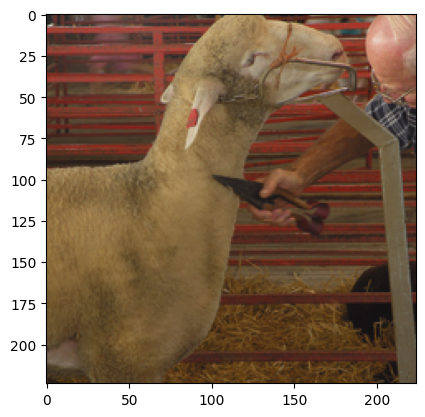

['the painted sky and the cloudy train', 'the cloudy sky and the painted train']


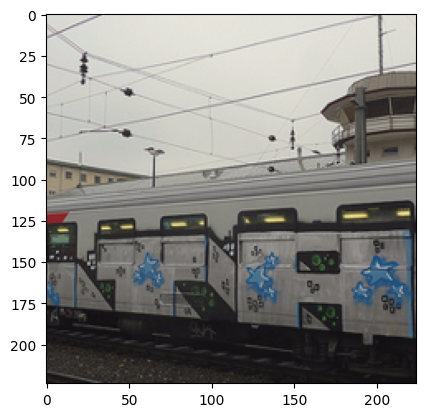

['the large scarf and the striped microwave', 'the striped scarf and the large microwave']


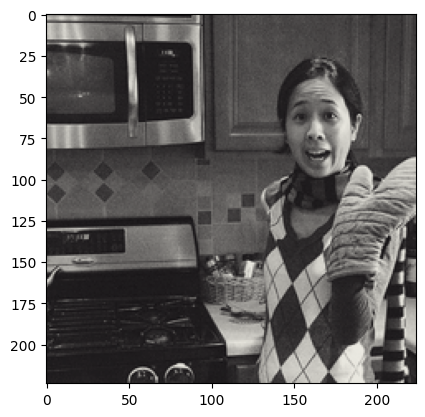

['the splashing surfer and the riding water', 'the riding surfer and the splashing water']


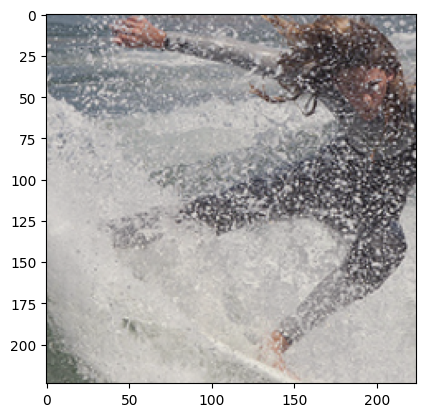

['the yellow table and the clear coffee mug', 'the clear table and the yellow coffee mug']


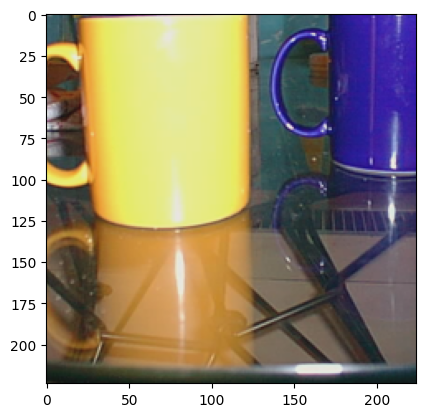

In [ ]:
for idx in range(400, 1000, 50):
    print(vga_dataset[idx]["caption_options"])
    normalize = T.Normalize(
        mean=[-m / s for m, s in zip([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])],
        std=[1/s for s in [0.229, 0.224, 0.225]]
    )

    to_pil = T.ToPILImage()
    image = normalize(vga_dataset[idx]["image_options"][0])
    image = to_pil(image)
    plt.imshow(image)
    plt.show()

In [ ]:
from dataset_zoo import get_dataset
coco_dataset = get_dataset("COCO_Order", image_preprocess=preprocess, download=True, root_dir="./coco_data")
coco_loader = DataLoader(coco_dataset, batch_size=16, shuffle=False)

0it [00:00, ?it/s]


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/home/loic/nltk_data'
    - '/home/loic/projects/vision-language-models-are-bows/.venv/nltk_data'
    - '/home/loic/projects/vision-language-models-are-bows/.venv/share/nltk_data'
    - '/home/loic/projects/vision-language-models-are-bows/.venv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************
